## 🤔 Setting Risk Parameters

This notebook describes conceptual and practical aspects of selecting tuning parameters which interpolate the training objective between average case performance and worst case performance. Recall that the goal of the learning algorithm is to find weights $w \in \mathbb{R}^d$ that solve

$$
    \min_{w \in \mathbb{R}^d} \max_{q \in \mathcal{Q}(\sigma)} \sum_{i=1}^n q_i \ell_i(w) - \nu \text{Pen}(q),
$$

where $\ell_1, \ldots, \ell_n$ are the losses on individual training examples, $\mathcal{Q}(\sigma)$ is an uncertainty set of probability weights that are parameterized by a vector $\sigma = (\sigma_1, \ldots, \sigma_n)$, $q \mapsto \nu \text{Pen}(q)$ is a penalty/regularization term whose stength is controlled by a parameter $\nu \geq 0$. The vector $\sigma$, called the *spectrum*, satisfies $0 \leq \sigma_1 \leq \ldots \leq \sigma_n$ and $\sum_{i=1}^n \sigma_i = 1$, and we have that $\mathcal{Q}(\sigma)$ is designed such that for any vector $l = (l_1, \ldots, l_n)$ with ordered elements $l_{(1)} \leq \ldots \leq l_{(n)}$, the central identity

$$
    \max_{q \in \mathcal{Q}(\sigma)} \langle q, l\rangle = \sum_{i=1}^n \sigma_i l_{(i)}
$$

holds. From the user's perspective, the **main hyperparameter to set is the spectrum**, as the penalty has negligible performance on the final output and only improves the optimization trajectory. Moreover, rather than selecting $n$ numbers, the spectra fall into broad classes that are each parameterized by univariate "risk" parameters. The rest of this notebook is dedicated to understanding the three spectra choices and their risk parameters.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from drlearn import make_superquantile_spectrum, make_extremile_spectrum, make_esrm_spectrum

**Superquantile:** The superquantile is a spectrum which places uniform weight on some proportion of the highest elements observed. Thus, we may specify this spectrum by the tail probability (proposition of elements retained) or the head probability (proportion of elements discarded). For simplicity, consider head probability $q$ such that $nq$ is an interger. Then, we have the formula

$$
    \sigma_i = \begin{cases}
    \frac{1}{1-q} & \text{ if } i > nq\\
    0 &\text{ otherwise}
    \end{cases}.
$$


The value $q$ corresponds to the `head_prob` parameter in `make_superquantile_spectrum`. When this is equal to zero, we recover the uniform wieghts $\sigma_i = 1/n$ for $i = 1, \ldots, n$, whereas `head_prob = (n-1)/n` recovers the maximum. See the illustration below.

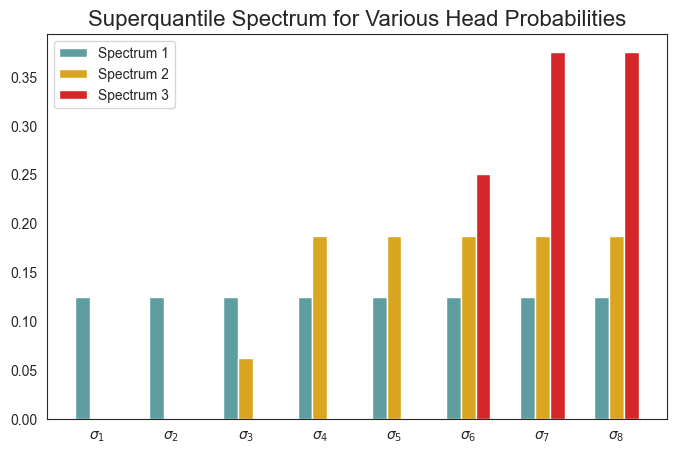

In [4]:
batch_size = 8

sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

offset = 0.2
colors = ["cadetblue", "goldenrod", "tab:red"]
x = np.arange(batch_size)
for i in range(3):
    spectrum = make_superquantile_spectrum(batch_size, i / 3.)
    ax.bar(x + i * offset, spectrum, color=colors[i], width=offset, label=f"Spectrum {i + 1}")
ax.legend(loc="upper left")
ax.set_title("Superquantile Spectrum for Various Head Probabilities", fontsize=16)
ax.set_xticks(x + offset)
ax.set_xticklabels([r"$\sigma_1$", r"$\sigma_2$", r"$\sigma_3$", r"$\sigma_4$", r"$\sigma_5$", r"$\sigma_6$", r"$\sigma_7$", r"$\sigma_8$"])
plt.show()

**Extremile:** The extremile weights are given by the spectrum

$$
    \sigma_i = (i/n)^{r} - ((i-1)/n)^{r}.
$$

The parameter $r$, which is equal to `n_draws` in `make_extremile_spectrum`, has the following interpretation when it is integer valued:

$$
    \sum_{i=1}^n \sigma_i l_{(i)} = \mathbb{E}[\max\{l_{i_1}, \ldots, l_{i_r}\}],
$$

where the expectation is taken over all uniformly random draws of indices $(i_1, \ldots, i_r)$ from $\{1, \ldots, n\}$. Thus, we recover uniform weights when $r=1$ and the maximum when $r \rightarrow \infty$. The parameter can be fractionally valued as well. See the figure below.

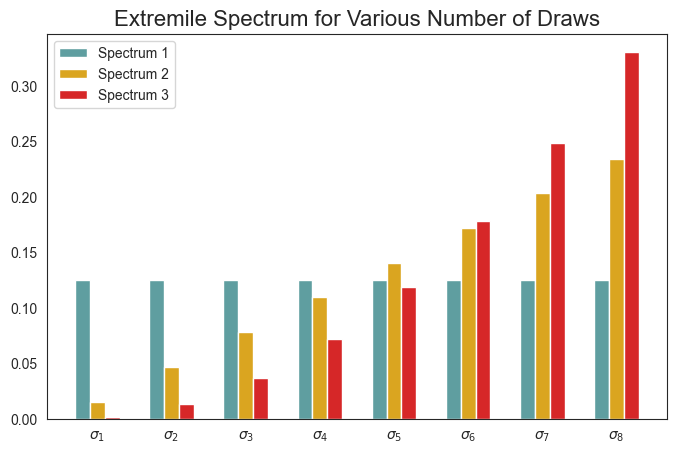

In [5]:
batch_size = 8

sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

offset = 0.2
colors = ["cadetblue", "goldenrod", "tab:red"]
x = np.arange(batch_size)
for i in range(3):
    spectrum = make_extremile_spectrum(batch_size, i + 1.)
    ax.bar(x + i * offset, spectrum, color=colors[i], width=offset, label=f"Spectrum {i + 1}")
ax.legend(loc="upper left")
ax.set_title("Extremile Spectrum for Various Number of Draws", fontsize=16)
ax.set_xticks(x + offset)
ax.set_xticklabels([r"$\sigma_1$", r"$\sigma_2$", r"$\sigma_3$", r"$\sigma_4$", r"$\sigma_5$", r"$\sigma_6$", r"$\sigma_7$", r"$\sigma_8$"])
plt.show()

**Exponential Spectral Risk Measure (ESRM):** Finally, we ESRM is given by spectrum

$$
    \sigma_i = \frac{e^{\rho }(e^{\rho i/ n} - e^{\rho(i-1)/n})}{1 - e^{-\rho}},
$$

where the value $\rho \geq 0$ is the risk aversion parameter. Setting $\rho = 0$ (or more formally, $\rho \rightarrow 0$) results in the uniform weights, and setting $\rho \rightarrow \infty$ recovers the maximum. This corresponds to the `risk_aversion` argument for `make_esrm_spectrum`. 
While this spectrum does not have as convenient an interpretation as the superquantile or extremile, we find in practice (and even in the visualizations below) that this spectrum performs very similarly to the extremile, and users can serve all of their purposes using the more interpretable extremile.

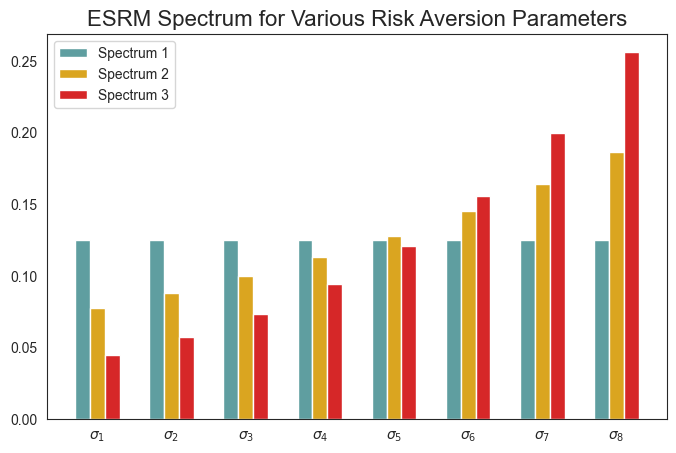

In [6]:
batch_size = 8

sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

offset = 0.2
colors = ["cadetblue", "goldenrod", "tab:red"]
x = np.arange(batch_size)
for i in range(3):
    spectrum = make_esrm_spectrum(batch_size, i)
    ax.bar(x + i * offset, spectrum, color=colors[i], width=offset, label=f"Spectrum {i + 1}")
ax.legend(loc="upper left")
ax.set_title("ESRM Spectrum for Various Risk Aversion Parameters", fontsize=16)
ax.set_xticks(x + offset)
ax.set_xticklabels([r"$\sigma_1$", r"$\sigma_2$", r"$\sigma_3$", r"$\sigma_4$", r"$\sigma_5$", r"$\sigma_6$", r"$\sigma_7$", r"$\sigma_8$"])
plt.show()